# Model Pipeline

[![colab badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mcallaghan/NLP-climate-science-tutorial-CCAI/blob/main/B_model_pipeline.ipynb)

In this notebook we'll go through the steps we need to take to load labelled data and train a model to predict a label based on text input. We'll start off with a simple model using Support Vector Machines (SVMs), before exploring how we would do this using by fine-tuning a language model using [transformers](https://huggingface.co/docs/transformers/index) 🤗

## Data

We'll start by loading our labels and merging these with the studies we downloaded from OpenAlex

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## If we are running in colab, mount google drive and change into the directory we cloned the repository into
if os.path.exists("/content/"):
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/NLP-climate-science-tutorial-CCAI")    

In [3]:
labelled_data = pd.read_csv("data/labelled_data.csv")

# We create a lower case version of the title without spaces and punctuation, to allow for merging
labelled_data["title_lcase"] = labelled_data["title"].apply(
    lambda x: re.sub("\W", "", x).lower()
)
# We also want to get rid of documents without abstracts, as we can't use these for learning
labelled_data = labelled_data.dropna(subset=["abstract"])
print(labelled_data.shape)
labelled_data.head()

(2500, 11)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,title_lcase
0,1448689,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,keyfactorsinfluencingtheincidenceofwestnilevir...
1,3281128,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...
2,900708,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...
3,3234419,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...
4,2090028,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...


In [4]:
# Now we load the Open alex data, and create the same title variable for merging

oa_data = pd.read_csv("data/openalex_data.csv").rename(columns={"id": "OA_id"})
oa_data["title_lcase"] = oa_data["title"].apply(lambda x: re.sub("\W", "", x).lower())
oa_data = oa_data.dropna(subset=["abstract"])
oa_data["seen"] = 0
print(oa_data.shape)
oa_data.head()

(8310, 8)


,OA_id,doi,title,publication_year,abstract,authors,title_lcase,seen
0,https://openalex.org/W2076977109,https://doi.org/10.1038/nature03906,Increasing destructiveness of tropical cyclone...,2005,Theory and modelling predict that hurricane in...,Kerry Emanuel,increasingdestructivenessoftropicalcyclonesove...,0
1,https://openalex.org/W2122582889,https://doi.org/10.1073/pnas.0505734102,Regional vegetation die-off in response to glo...,2005,Future drought is projected to occur under war...,"David D. Breshears, Neil S. Cobb, Paul M. Rich...",regionalvegetationdieoffinresponsetoglobalchan...,0
2,https://openalex.org/W2171979944,https://doi.org/10.1007/s00425-003-1105-5,"Plant responses to drought, salinity and extre...",2003,"Abiotic stresses, such as drought, salinity, e...","Wangxia Wang, Basia Vinocur, Arie Altman",plantresponsestodroughtsalinityandextremetempe...,0
3,https://openalex.org/W2161828152,https://doi.org/10.1073/pnas.0901438106,Temperature sensitivity of drought-induced tre...,2009,Large-scale biogeographical shifts in vegetati...,"Henry D. Adams, Maite Guardiola-Claramonte, Gr...",temperaturesensitivityofdroughtinducedtreemort...,0
4,https://openalex.org/W2612322017,NaN,Resilience of ecosystems: local surprise and g...,1985,Presents a conceptual framework that can help ...,C. S. Holling,resilienceofecosystemslocalsurpriseandglobalch...,0


In [5]:
# Now we add the OpenAlex rows which are not in the labelled data to the labelled_data
df = pd.concat(
    [labelled_data, oa_data[~oa_data["title_lcase"].isin(labelled_data["title_lcase"])]]
)
print(df.shape)
df.head()

(10736, 15)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,title_lcase,OA_id,doi,publication_year,authors
0,1448689.0,"The city of Bismarck, North Dakota has one of ...",Key Factors Influencing the Incidence of West ...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,keyfactorsinfluencingtheincidenceofwestnilevir...,NaN,NaN,NaN,NaN
1,3281128.0,Changing precipitation regimes can profoundly ...,Asymmetric responses of plant community struct...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,asymmetricresponsesofplantcommunitystructurean...,NaN,NaN,NaN,NaN
2,900708.0,Climate influences forest structure through ef...,Climate effects on fire regimes and tree recru...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,climateeffectsonfireregimesandtreerecruitmenti...,NaN,NaN,NaN,NaN
3,3234419.0,"Climate change is likely to bring more, hotter...",Climate change adaptation and mitigation ? a h...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatechangeadaptationandmitigationahitherton...,NaN,NaN,NaN,NaN
4,2090028.0,Aim The long-term stability of coastal ecosyst...,Caribbean mangroves adjust to rising sea level...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,caribbeanmangrovesadjusttorisingsealevelthroug...,NaN,NaN,NaN,NaN


### Inspecting our labels

We can take a quick look at how many of which type of labels we have

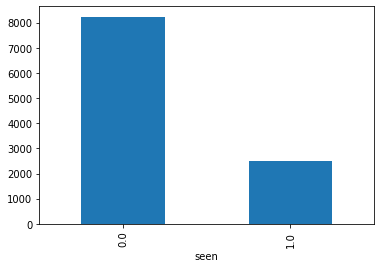

In [6]:
# We can quickly plot how many documents have been labelled, and how many not
df.groupby("seen")["title"].count().plot.bar();

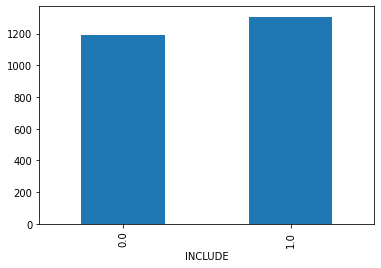

In [7]:
# TODO: I don't understand what the INCLUDE label means, could you explain how a paper would get this designation?
# and also plot how many of the labelled docs were included
df.groupby("INCLUDE")["title"].count().plot.bar();

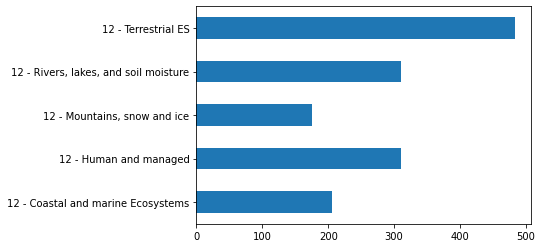

In [8]:
# Finally we can plot how many examples of each impact type we have

impacts = [x for x in df.columns if re.match("12 -", x)]
df[impacts].sum().plot.barh();

## A pipeline for a simple machine learning model

Now we want to put together a pipeline for a simple machine learning model. We'll start off by trying to predict the binary INCLUSION label, then move onto the impact type, which is a **multilabel** output. This means each document can be labelled with one or more of the impact types. 

In each case, though, the first thing we need to do is to encode our text input numerically, so it can be used in our models. To do this, we'll take a look at approaches from the feature extraction module from [scikitlearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text): `CountVectorizer` and `TfidfVectorizer`.

In [9]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Let's take for now a couple of example texts
texts = [
    "Climate change is impacting human systems",
    "Climate change is caused by fossil fuels",
    "System change not climate change",
]

# We'll instantiate a vectorizer class
vectorizer = CountVectorizer()

# And apply the fit_transform method to our texts
X = vectorizer.fit_transform(texts)

# This gives us a matrix of shape n_texts, vocab_size
X.todense()

matrix([[0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0]])

[[0 0 1 1 0 0 1 1 1 0 0 1]
 [1 1 1 1 1 1 0 0 1 0 0 0]
 [0 0 2 1 0 0 0 0 0 1 1 0]]


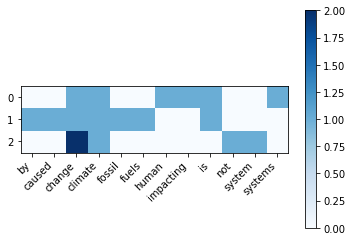

In [10]:
# The features each column represents can be accessed here
features = vectorizer.get_feature_names_out()


def visualize_doc_vec(X, features=None):
    print(X.todense())
    # And we could visualise this simply like this
    fig, ax = plt.subplots()
    doc_map = ax.imshow(X.todense(), cmap="Blues")
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features, rotation=45, ha="right")
    cbar = fig.colorbar(doc_map)


visualize_doc_vec(X, features)

plt.show()

As we can see, each document is a row, each column is a feature. The cells contain the number of times each word occurs in each document. 

However, by adding a small amount of complexity we can generate a more useful way of representing these texts. 

Term frequency inverse document frequency ([TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) gives greater weight to those terms which appear infrequently in the corpus, meaning that very frequent but uninformative terms like "the" are given less importance.

[[0.         0.         0.28561676 0.28561676 0.         0.
  0.48359121 0.48359121 0.36778358 0.         0.         0.48359121]
 [0.43535684 0.43535684 0.25712876 0.25712876 0.43535684 0.43535684
  0.         0.         0.3311001  0.         0.         0.        ]
 [0.         0.         0.61046311 0.30523155 0.         0.
  0.         0.         0.         0.51680194 0.51680194 0.        ]]


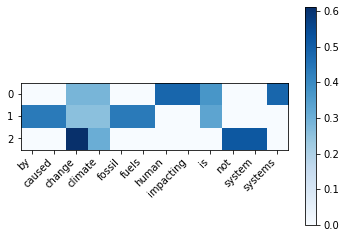

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

features = vectorizer.get_feature_names_out()

visualize_doc_vec(X, features)

plt.show()

## Learning from features

Support Vector machines work by finding a hyperplane in a multi-dimensional space that separates samples of different classes. The matrix we have visualised above forms our multidimensional space.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

clf = Pipeline(
    steps=[
        ("vect", TfidfVectorizer()),
        ("clf", SVC(probability=True, class_weight="balanced")),
    ]
)

# We'll slightly expand our list of texts
texts, y = zip(
    *[
        ("Climate change is impacting human systems", 1),
        ("Climate change is caused by fossil fuels", 0),
        ("Agricultural yields are affected by climate change", 1),
        ("System change not climate change", 0),
        ("higher temperatures are impacting human health", 1),
        ("Forest fires are becoming more frequent due to climate change", 1),
        ("Machine learning can read texts", 0),
        ("AI can help solve climate change!", 0),
        ("We need to save gas this winter", 0),
        ("More frequent droughts are impacting crop yields", 1),
        ("Many communities are affected by rising sea levels", 1),
        ("Global emissions continue to rise", 0),
        ("Ecosystems are increasingly impacted by rising temperatures", 1),
        ("Emissions from fossil fuels need to decline", 0),
        ("Anthropogenic climate change is impacting vulnerable communities", 1),
    ]
)

clf.fit(texts, y)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', SVC(class_weight='balanced', probability=True))])

In [13]:
# We can now use this classifier to make predictions about new texts

# Here are a couple of easy examples (easy because they are similar to our examples)
new_texts = [
    "climate change is impacting terrestrial ecosystems",
    "Machine Learning will solve climate change",
    "Fossil fuels are responsible for rising temperature",
]
# We can make predictions about which class the examples belong to
clf.predict(new_texts)

array([1, 0, 0])

In [14]:
# We can also get these as probabilities (which are very unstable with small datasets, and not guaranteed to match the predictions)
clf.predict_proba(new_texts)

array([[0.52031527, 0.47968473],
       [0.39734698, 0.60265302],
       [0.44653469, 0.55346531]])

In [15]:
# Each row contains predicted probabilites for each class, in this case 0, and 1

# We can get predicted probabilities of being in the INCLUDE class like this
clf.predict_proba(new_texts)[:, 1]

array([0.47968473, 0.60265302, 0.55346531])

## Multilabel

Multilabel problems are those where any sample can belong to any of the classes (as opposed to multiclass problems where each sample must belong to **exactly 1** class. In our dataset, most documents which were marked as relevant are assigned to one class, with some assigned to two, and very few assigned to three.

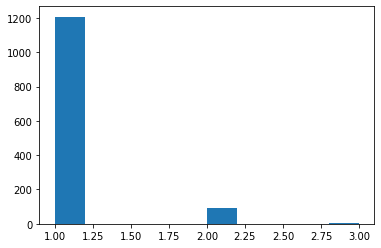

In [16]:
plt.hist(df[df["INCLUDE"] == 1][impacts].sum(axis=1));

To prepare our target for the model, we simply create a matrix with a row for each document and a column for each class

In [17]:
# create an x and y variable with a sample of 200 relevant documents
samples = df[df["INCLUDE"] == 1].sample(200).index
X = df.iloc[samples]["abstract"]
y = df.iloc[samples][impacts].values
np.set_printoptions(threshold=5)
y

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0.]])

Now we just need to slightly amend our pipeline by defining how we want to approach the multilabel problem.

We use a One vs Rest classifier which simply creates a binary classifier for each class

In [18]:
from sklearn.multiclass import OneVsRestClassifier

clf = Pipeline(
    steps=[
        ("vec", TfidfVectorizer()),
        ("clf", OneVsRestClassifier(SVC(probability=True, class_weight="balanced"))),
    ]
)

clf.fit(X, y)

Pipeline(steps=[('vec', TfidfVectorizer()),
                ('clf',
                 OneVsRestClassifier(estimator=SVC(class_weight='balanced',
                                                   probability=True)))])

In the same way as before, we can make predictions with some sample texts

In [19]:
example_texts = [
    "Climate change has affected butterfly phenology in North America. "
    + "In an experiment in the butterfly national park, we found that "
    + "mean dates of appearance had shifted by two weeks. Species traits, "
    + "especially ecological traits, were found to explain some part of "
    + "different phenological responses",
    "Rising temperatures have contributed to increasing heat related mortaility "
    + "in cities across Europe. ",
]
y_pred = clf.predict(example_texts)

pd.DataFrame(y_pred, columns=impacts)

,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES
0,0,0,0,0,1
1,0,0,0,0,0


## Transfer learning with transformers!

A more powerful way to do classification is to fine-tune a langauge model which has been pretrained on large amounts of text. For an introduction to how these work (which is outside the scope of this tutorial) check out [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/).

The [Transformers](https://huggingface.co/docs/transformers) library makes doing this really easy, and there are a wealth of models available with different features and which have been pretrained on different corpora. We are going to use [ClimateBert](https://huggingface.co/climatebert), which has undergone additional pretraining on texts from the climate domain (included scientific articles).

In [30]:
# Let's take our texts and our labels again
texts, y = zip(
    *[
        ("Climate change is impacting human systems", 1),
        ("Climate change is caused by fossil fuels", 0),
        ("Agricultural yields are affected by climate change", 1),
        ("System change not climate change", 0),
        ("higher temperatures are impacting human health", 1),
        ("Forest fires are becoming more frequent due to climate change", 1),
        ("Machine learning can read texts", 0),
        ("AI can help solve climate change!", 0),
        ("We need to save gas this winter", 0),
        ("More frequent droughts are impacting crop yields", 1),
        ("Many communities are affected by rising sea levels", 1),
        ("Global emissions continue to rise", 0),
        ("Ecosystems are increasingly impacted by rising temperatures", 1),
        ("Emissions from fossil fuels need to decline", 0),
        ("Anthropogenic climate change is impacting vulnerable communities", 1),
    ]
)

In [31]:
# To use these with transformers, we are going to need to get them into the right format.
from datasets import Dataset
from transformers import AutoTokenizer

# First we'll put them into a HuggingFace Dataset object
dataset = Dataset.from_dict({"text": texts, "label": y})

# And now we need to tokenize the texts, using the pretrained tokenizer from climatebert
model_name = "climatebert/distilroberta-base-climate-f"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="longest", truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset[0]

loading file https://huggingface.co/climatebert/distilroberta-base-climate-f/resolve/main/vocab.json from cache at /home/max/.cache/huggingface/transformers/3ba94d8982c0e7ecd7248128e9e8fa5c4eceee0814c8b52f535446a7b1743967.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/climatebert/distilroberta-base-climate-f/resolve/main/merges.txt from cache at /home/max/.cache/huggingface/transformers/624a724a2a3c05a06900248de445daf260f4d25a0079867ce8e86ce1e9cb02fb.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
loading file https://huggingface.co/climatebert/distilroberta-base-climate-f/resolve/main/tokenizer.json from cache at /home/max/.cache/huggingface/transformers/386ec1a73d82cb91a321af42898c8bd388502e07fe471389e3a6cd9954f49361.5196e959786990f52908322f6e7c0c5ed92d9a7392df9288c3cc19ec72195a09
loading file https://huggingface.co/climatebert/distilroberta-base-climate-f/resolve/main/added_tokens.json from cache at /home/max/.ca

  0%|          | 0/1 [00:00<?, ?ba/s]

{'text': 'Climate change is impacting human systems',
 'label': 1,
 'input_ids': [0, 40466, 464, 16, 18081, 1050, 1437, 50333, 2, 1, 1, 1, 1],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]}

In [32]:
# We can wrap this into one function that turns any set of texts (and optional labels)
# into a tokenized huggingface dataset
def datasetify(x, tokenizer, y=None):
    data_dict = {"text": x}
    if y is not None:
        data_dict["label"] = y
    dataset = Dataset.from_dict(data_dict)

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="longest", truncation=True)

    return dataset.map(tokenize_function, batched=True)


tokenized_dataset = datasetify(texts, tokenizer, y)
tokenized_dataset[0]

  0%|          | 0/1 [00:00<?, ?ba/s]

{'text': 'Climate change is impacting human systems',
 'label': 1,
 'input_ids': [0, 40466, 464, 16, 18081, 1050, 1437, 50333, 2, 1, 1, 1, 1],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]}

In [35]:
# Now we want to load our model, and instantiate a Trainer class
from transformers import AutoModelForSequenceClassification, Trainer, logging

logging.set_verbosity_warning()

# We set num_labels to 2 for binary classification, as we have two classes - positive and negative
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# The trainer class needs to be supplied with a model, and a dataset (and will also accept TrainingArguments and validation data)
trainer = Trainer(model=model, train_dataset=datasetify(texts, tokenizer, y))
# Once this has been instantiated we can apply the train() method
trainer.train()

Some weights of the model checkpoint at climatebert/distilroberta-base-climate-f were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6, training_loss=0.6805674235026041, metrics={'train_runtime': 4.2459, 'train_samples_per_second': 10.598, 'train_steps_per_second': 1.413, 'total_flos': 151354351980.0, 'train_loss': 0.6805674235026041, 'epoch': 3.0})

In [36]:
# To generate predictions, we just need to supply a dataset to the predict method
new_texts = [
    "climate change is impacting terrestrial ecosystems",
    "Machine Learning will solve climate change",
    "Fossil fuels are responsible for rising temperature",
]


pred = trainer.predict(datasetify(new_texts, tokenizer, [1, 0, 0]))
pred

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3
  Batch size = 8


PredictionOutput(predictions=array([[ 0.03344734,  0.04020789],
       [ 0.08351195, -0.0437724 ],
       [ 0.06292889, -0.0039019 ]], dtype=float32), label_ids=array([1, 0, 0]), metrics={'test_loss': 0.6605305075645447, 'test_runtime': 0.043, 'test_samples_per_second': 69.692, 'test_steps_per_second': 23.231})

In [38]:
# However, the model output gives us logits. If these are negative, then the prediction
# is negative, if they are positive, the prediction is positive.
# We can turn these into probabilities with an activation function
from torch import tensor
from torch.nn import Sigmoid, Softmax

activation = (
    Softmax()
)  # Since we have two exclusive classes, we use the Softmax function
activation(tensor(pred.predictions))

/tmp/ipykernel_20245/30200511.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  activation(tensor(pred.predictions))


tensor([[0.4983, 0.5017],
        [0.5318, 0.4682],
        [0.5167, 0.4833]])

In [39]:
# If we want to always get probabilities, we can subclass Trainer and add a new predict_proba method

from transformers.trainer_utils import PredictionOutput


class ProbTrainer(Trainer):
    def predict_proba(self, test_dataset: Dataset) -> PredictionOutput:
        logits = self.predict(test_dataset).predictions
        if logits.shape[1] > 2:
            activation = Sigmoid()
        else:
            activation = Softmax()
        return activation(tensor(logits)).numpy()


trainer = ProbTrainer(model=model, train_dataset=datasetify(texts, tokenizer, y))
trainer.train()

pred = trainer.predict_proba(datasetify(new_texts, tokenizer))
pred

  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3
  Batch size = 8


/tmp/ipykernel_20245/3742539908.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return activation(tensor(logits)).numpy()


array([[0.40779403, 0.59220594],
       [0.61067414, 0.38932583],
       [0.5248192 , 0.47518077]], dtype=float32)

In [40]:
### To do multilabel learning, we just need the data in the same format as before
# create an x and y variable with a sample of 200 relevant documents
samples = df[df["INCLUDE"] == 1].sample(5).index
X = df.iloc[samples]["abstract"]
y = df.iloc[samples][impacts].values
y

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [42]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
trainer = ProbTrainer(model=model, train_dataset=datasetify(X, tokenizer, y))
trainer.train()

pred = trainer.predict_proba(datasetify(new_texts, tokenizer))
pred

loading configuration file https://huggingface.co/climatebert/distilroberta-base-climate-f/resolve/main/config.json from cache at /home/max/.cache/huggingface/transformers/82c3d717cd158a55810d12484b95ea019844ecb6e5e860ead378d0d98b2c190a.2ae894217f03434702f7a4881de106e5bd76e3f3bd6ee1f81fd1551c47bc898d
Model config RobertaConfig {
  "_name_or_path": "climatebert/distilroberta-base-climate-f",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_em

  0%|          | 0/1 [00:00<?, ?ba/s]

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3
  Batch size = 8


array([[0.5063088 , 0.5171989 , 0.5075089 , 0.48348302, 0.451609  ],
       [0.5074933 , 0.5217197 , 0.5122858 , 0.4859028 , 0.4514132 ],
       [0.508191  , 0.5170327 , 0.5082103 , 0.48727104, 0.45309764]],
      dtype=float32)